In [1]:
#importing package for GraphQl for python
from gql import gql,Client
from gql.transport.requests import RequestsHTTPTransport

In [2]:
import pandas as pd
import numpy as np

In [3]:
samp_transport=RequestsHTTPTransport(
    url='https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2',
    verify=True,
    retries=5,
)

In [4]:
client = Client(
transport = samp_transport
)

In [5]:
#calling query
id_query_1 = gql('''
query {
  pairs {
    id
  }
}''')

resp = client.execute(id_query_1)
#listing the results
resp_list = []
for res_id in resp['pairs'] :
    resp_list.append(res_id['id'])
    
resp_list

['0x00004ee988665cdda9a1080d5792cecd16dc1220',
 '0x0000871c95bb027c90089f4926fd1ba82cdd9a8b',
 '0x00030110a7053083a7a160449a0e8f1adce9438d',
 '0x00031554ee74e4a6d497677e5152d94c3dbe5f46',
 '0x0003713f74bc8c3435f4499eb0cbc6298cd1529d',
 '0x00048cf1acdb5fa81a0facf869ef60c3f49bfe36',
 '0x0004ecc9fdb2dac546a215abeb7ce73439f96cd1',
 '0x0005ee2ef3f313ae168451ef8174b4fcc508819f',
 '0x0006bc3e52137a1873d7d8cd779a7e138bb7e929',
 '0x000a7f585c99791e49fa75fdbfbc8588a1f6ffc8',
 '0x000bc4f31d2c8dcc66f6f1c93bb00920e3ea6c5d',
 '0x000c5583ec00b076c41292484b3a24c3416583f0',
 '0x000c5c3905733ad4abe97bd7c52170d9ddf116ee',
 '0x000d6bc79e6d73bdd2099942f3fd4b87f8e3c33c',
 '0x000dd0b1528a396c6ea2e09796a7b4a534e9e37b',
 '0x0010b1d178614e65c877fc5ff8c1b469c2cdbb14',
 '0x0012ab271b58299c90b597fad5cc45e30450105c',
 '0x00146b23e4861b00f6c242c25fbcbc72f5dbae69',
 '0x00153b7c47163a2c2fabd9eb44745678f709800d',
 '0x001631be213ed129110990e31667cd954970243f',
 '0x00169b1dd92b039a94d33f65c31bf1c297657a72',
 '0x0016e7ef0

In [6]:
#naming the coin for swapping
token0_list = []
token1_list = []
responsel = []
for i in range(len(resp_list)) :
    id_query_2 = gql('''
    query {
     swaps(where:{pair: ''' + str('"') + resp_list[i] + str('"') + '''}, orderBy: timestamp, orderDirection: desc, 
     ) {
        id
        pair {
          token0 {
            id
            symbol
          }
          token1 {
            id
            symbol
          }
        }
      }
    }
    ''')
    
    resp1 = client.execute(id_query_2)
    if resp1['swaps'] :
        token0_list.append(resp1['swaps'][0]['pair']['token0']['symbol'])
        token1_list.append(resp1['swaps'][0]['pair']['token1']['symbol'])
        responsel.append(resp_list[i])
    
#results to DF
token_df = pd.DataFrame()
token_df['Token0'] = token0_list
token_df['Token1'] = token1_list
token_df['ID'] = responsel

#Selecting Only the IDS involving with WETH
token_df = token_df[(token_df['Token0'] == 'WETH') | (token_df['Token1'] == 'WETH')].reset_index(drop=True)
token_df

,Token0,Token1,ID
0,HORE,WETH,0x0000871c95bb027c90089f4926fd1ba82cdd9a8b
1,SOMEE,WETH,0x00030110a7053083a7a160449a0e8f1adce9438d
2,DATCx,WETH,0x00031554ee74e4a6d497677e5152d94c3dbe5f46
3,WGRT,WETH,0x0003713f74bc8c3435f4499eb0cbc6298cd1529d
4,COCK,WETH,0x00048cf1acdb5fa81a0facf869ef60c3f49bfe36
...,...,...,...
72,YIFX,WETH,0x00a34e3d446550647cba3a5c73dd3e9555f0e8b4
73,SAKITA,WETH,0x00a3feba4775abfc5427c261cbfab547d0118fe6
74,BASE,WETH,0x00a61050e350aff052726cb597f435cbd6c50b3b
75,APPLE,WETH,0x00a61ae19250444503f6a1de1779b56104ebf0c0


In [7]:
#trade details for weth coin involved trns

sv_kv_df = pd.DataFrame()
for id_itr in token_df['ID'].values :
    query1 = gql('''
    query {
     swaps(where:{pair: ''' + str('"') + id_itr + str('"') + '''}, orderBy: timestamp, orderDirection: desc, 
     ) {
        id
        timestamp
        amount0In
        amount1In
        amount0Out
        amount1Out
    
        pair {
        volumeUSD
        token0Price
        token1Price
          token0 {
            id
            symbol
          }
          token1 {
            id
            symbol
          }
        }
        transaction {
          blockNumber
        }
      }
    }

    ''')
    
    responses = client.execute(query1)
    
    buy_list = []
    sell_list = []
    buy_sym_list = []
    sell_sym_list = []
    id_list = []
    timestamp_list = []
    volume_usd_list = []
    token0_price_list = []
    token1_price_list = []

    for resp in responses['swaps'] :
        sell_list.append(resp['amount0In'])
        buy_list.append(resp['amount1Out'])
        id_list.append(resp['id'])
        sell_sym_list.append(resp['pair']['token0']['symbol'])
        buy_sym_list.append(resp['pair']['token1']['symbol'])
        timestamp_list.append(resp['timestamp'])
        volume_usd_list.append(resp['pair']['volumeUSD'])
        token0_price_list.append(resp['pair']['token0Price'])
        token1_price_list.append(resp['pair']['token1Price'])

    sv_df = pd.DataFrame()
    sv_df['Timestamp'] = timestamp_list
    sv_df['Sell Symbol'] = sell_sym_list
    sv_df['Buy Symbol'] = buy_sym_list
    sv_df['Sell Quantity'] = sell_list
    sv_df['Buy Quantity'] = buy_list
    sv_df['Volume in USD'] = volume_usd_list
    sv_df['Sell Price'] = token0_price_list
    sv_df['Buy Price'] = token1_price_list
    sv_df['ID'] = id_list
    
    sv_kv_df = pd.concat([sv_kv_df, sv_df], axis=0)

sv_kv_df.head()


,Timestamp,Sell Symbol,Buy Symbol,Sell Quantity,Buy Quantity,Volume in USD,Sell Price,Buy Price,ID
0,1601773587,HORE,WETH,37.894166416941364499,0.752528697106688055,0,50.74468085106382978723404255319149,0.01970649895178197064989517819706499,0x78dd2006cd5f406cf9752adfac6d870c9066433a3806...
1,1601773587,HORE,WETH,10,0.199627856551804117,0,50.74468085106382978723404255319149,0.01970649895178197064989517819706499,0x326b76560c42adfda31a64bf28d7a2abe9042440c09b...
2,1601773587,HORE,WETH,0,0,0,50.74468085106382978723404255319149,0.01970649895178197064989517819706499,0x2782a498aa07789298fbd5e17368227699494de8d705...
3,1601773570,HORE,WETH,55,1.309136213684552726,0,50.74468085106382978723404255319149,0.01970649895178197064989517819706499,0x8906245f4e8152e7d7e644d3fca6cd53c68f619206a9...
4,1601773562,HORE,WETH,0,0,0,50.74468085106382978723404255319149,0.01970649895178197064989517819706499,0x07ba4fd03cf9b9e8d328939e654b845ef55915d8fb5f...


In [8]:
#we'll try to remove 0 quantity trns

In [9]:
sv_kv_df.shape

(3412, 9)

In [10]:
from datetime import datetime

In [11]:
sv_kv_df['Timestamp_alt'] = pd.to_datetime(sv_kv_df['Timestamp'].apply(lambda x : datetime.fromtimestamp(int(x)).strftime('%d-%m-%y %H:%M:%S')))

sv_kv_df['Sell Quantity'] = sv_kv_df['Sell Quantity'].astype('float')
sv_kv_df['Buy Quantity'] = sv_kv_df['Buy Quantity'].astype('float')
sv_kv_df['Volume in USD'] = sv_kv_df['Volume in USD'].astype('float')
sv_kv_df['Sell Price'] = sv_kv_df['Sell Price'].astype('float')
sv_kv_df['Buy Price'] = sv_kv_df['Buy Price'].astype('float')

sv_kv_df = sv_kv_df[(sv_kv_df['Sell Quantity'] != 0) & (sv_kv_df['Buy Quantity'] != 0)].reset_index(drop=True)
sv_kv_df['Buy/Sell'] = np.where(sv_kv_df['Buy Symbol'] == 'WETH', 'Buy', 'Sell')

sv_kv_df.head()

,Timestamp,Sell Symbol,Buy Symbol,Sell Quantity,Buy Quantity,Volume in USD,Sell Price,Buy Price,ID,Timestamp_alt,Buy/Sell
0,1601773587,HORE,WETH,37.894166,0.752529,0.0,50.744681,0.019706,0x78dd2006cd5f406cf9752adfac6d870c9066433a3806...,2020-04-10 06:36:27,Buy
1,1601773587,HORE,WETH,10.000000,0.199628,0.0,50.744681,0.019706,0x326b76560c42adfda31a64bf28d7a2abe9042440c09b...,2020-04-10 06:36:27,Buy
2,1601773570,HORE,WETH,55.000000,1.309136,0.0,50.744681,0.019706,0x8906245f4e8152e7d7e644d3fca6cd53c68f619206a9...,2020-04-10 06:36:10,Buy
3,1601773526,HORE,WETH,50.000000,1.114699,0.0,50.744681,0.019706,0x1434adab1151db023ae3585f5444a97fb3aaad9d1395...,2020-04-10 06:35:26,Buy
4,1601773509,HORE,WETH,45.732531,1.241010,0.0,50.744681,0.019706,0x5a4a04e84732a3db5431533a3a483ca6467ee89a4ae2...,2020-04-10 06:35:09,Buy


In [12]:
sv_kv_df.shape

(1492, 11)

In [13]:
#trying to remove volume 0 in USD

In [14]:
stockcoin_df = pd.DataFrame()

stockcoin_df['Timestamp'] = sv_kv_df['Timestamp_alt']
stockcoin_df['Side'] = sv_kv_df['Buy/Sell']
stockcoin_df['Base_Currency'] = np.where(sv_kv_df['Buy/Sell'] == 'Buy', sv_kv_df['Buy Symbol'], sv_kv_df['Sell Symbol'])
stockcoin_df['Quoted_Currency'] = np.where(sv_kv_df['Buy/Sell'] == 'Buy', sv_kv_df['Sell Symbol'], sv_kv_df['Buy Symbol'])
stockcoin_df['Base_Currency_Quant_Traded'] = np.where(sv_kv_df['Buy/Sell'] == 'Buy', sv_kv_df['Buy Quantity'], sv_kv_df['Sell Quantity'])
stockcoin_df['Quoted_Currency_Quant_Traded'] = np.where(sv_kv_df['Buy/Sell'] == 'Buy', sv_kv_df['Sell Quantity'], sv_kv_df['Buy Quantity'])
stockcoin_df['Volume in USD'] = np.where(sv_kv_df['Buy/Sell'] == 'Buy', sv_kv_df['Buy Quantity']/sv_kv_df['Buy Price'], sv_kv_df['Sell Quantity']/sv_kv_df['Sell Price'])
stockcoin_df['ID'] = sv_kv_df['ID']

stockcoin_df.head()

,Timestamp,Side,Base_Currency,Quoted_Currency,Base_Currency_Quant_Traded,Quoted_Currency_Quant_Traded,Volume in USD,ID
0,2020-04-10 06:36:27,Buy,WETH,HORE,0.752529,37.894166,38.186829,0x78dd2006cd5f406cf9752adfac6d870c9066433a3806...
1,2020-04-10 06:36:27,Buy,WETH,HORE,0.199628,10.000000,10.130052,0x326b76560c42adfda31a64bf28d7a2abe9042440c09b...
2,2020-04-10 06:36:10,Buy,WETH,HORE,1.309136,55.000000,66.431699,0x8906245f4e8152e7d7e644d3fca6cd53c68f619206a9...
3,2020-04-10 06:35:26,Buy,WETH,HORE,1.114699,50.000000,56.565026,0x1434adab1151db023ae3585f5444a97fb3aaad9d1395...
4,2020-04-10 06:35:09,Buy,WETH,HORE,1.241010,45.732531,62.974663,0x5a4a04e84732a3db5431533a3a483ca6467ee89a4ae2...


In [15]:
stockcoin_df[(stockcoin_df['Side'] == 'Sell')]

,Timestamp,Side,Base_Currency,Quoted_Currency,Base_Currency_Quant_Traded,Quoted_Currency_Quant_Traded,Volume in USD,ID
276,2021-06-23 00:06:23,Sell,WETH,ISP,0.516721,1.052143e+06,1.032842e+06,0xe81d03717e3012a9ded833c1a18ceb673eb3451bc086...
277,2021-06-22 23:16:46,Sell,WETH,ISP,0.020000,4.164212e+04,3.997677e+04,0x2faa26a515f319282f13f69c122a4851029ca919ace9...
278,2021-06-22 12:55:58,Sell,WETH,ISP,0.003310,6.856493e+03,6.616765e+03,0xd201151532a0c9c9487f5b9fe40d0f1af9309b09bb8d...
279,2021-06-22 12:50:51,Sell,WETH,ISP,0.302778,6.352980e+05,6.052036e+05,0x17b430483034a40ccd3c182f4f86374ff4464642f084...
280,2021-06-22 10:07:14,Sell,WETH,ISP,0.359984,7.295965e+05,7.195493e+05,0x47220a60c8ce253bd94c48509cb83ad3c67423745f8a...
...,...,...,...,...,...,...,...,...
1487,2021-05-27 05:11:46,Sell,WETH,TINO,0.100000,2.682736e+10,5.111143e+07,0x57d8b543d305b7aefa49402a915f39e2f4989e012a19...
1488,2021-05-27 05:10:44,Sell,WETH,TINO,0.100000,2.850680e+10,5.111143e+07,0xd1da6b415f425d862c1dc681cab82aaad452f9c84da2...
1489,2021-05-27 05:10:10,Sell,WETH,TINO,0.030000,8.903052e+09,1.533343e+07,0x5dcc6c343e10cdc57dc3a56ea32ed6ba72febf5a876e...
1490,2021-05-27 05:09:12,Sell,WETH,TINO,0.060000,1.832254e+10,3.066686e+07,0x88c42227290fadfc30877bebd85fabaff2a1d9befde5...


In [16]:
## Exporting Final df to csv for analysis purpose

In [17]:
stockcoin_df.to_csv('Cryptocurrency.csv', index=False)

# ANALYSIS

In [18]:
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('Cryptocurrency.csv')

In [20]:
df.dtypes

Timestamp                        object
Side                             object
Base_Currency                    object
Quoted_Currency                  object
Base_Currency_Quant_Traded      float64
Quoted_Currency_Quant_Traded    float64
Volume in USD                   float64
ID                               object
dtype: object

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
df.describe()

,Base_Currency_Quant_Traded,Quoted_Currency_Quant_Traded,Volume in USD
count,1.492000e+03,1.492000e+03,1.492000e+03
mean,6.066608e-01,2.242981e+13,2.815653e+25
std,4.449134e+00,1.697528e+14,1.782159e+26
min,1.000000e-18,1.700000e-17,7.011616e-23
25%,6.168331e-02,1.343443e+02,4.396834e+02
50%,1.874352e-01,1.200000e+04,2.321813e+04
75%,5.000000e-01,9.591391e+05,5.201350e+06
max,1.532027e+02,2.881976e+15,2.553317e+27


In [23]:
buy_share_df = df[df['Side'] == 'Buy'].groupby(['Base_Currency', 'Quoted_Currency'])[['Volume in USD']].mean().reset_index().sort_values('Volume in USD', ascending=False).reset_index(drop=True)
sell_share_df = df[df['Side'] == 'Sell'].groupby(['Base_Currency', 'Quoted_Currency'])[['Volume in USD']].mean().reset_index().sort_values('Volume in USD', ascending=False).reset_index(drop=True)

buy_share_df.head()

,Base_Currency,Quoted_Currency,Volume in USD
0,WETH,HOSHI,1.767337e+15
1,WETH,SILVA,4.369270e+12
2,WETH,UGLYSHIB,8.027902e+09
3,WETH,PAYPAL,6.735182e+09
4,WETH,SAKITA,1.831795e+09


In [24]:
import seaborn as sns

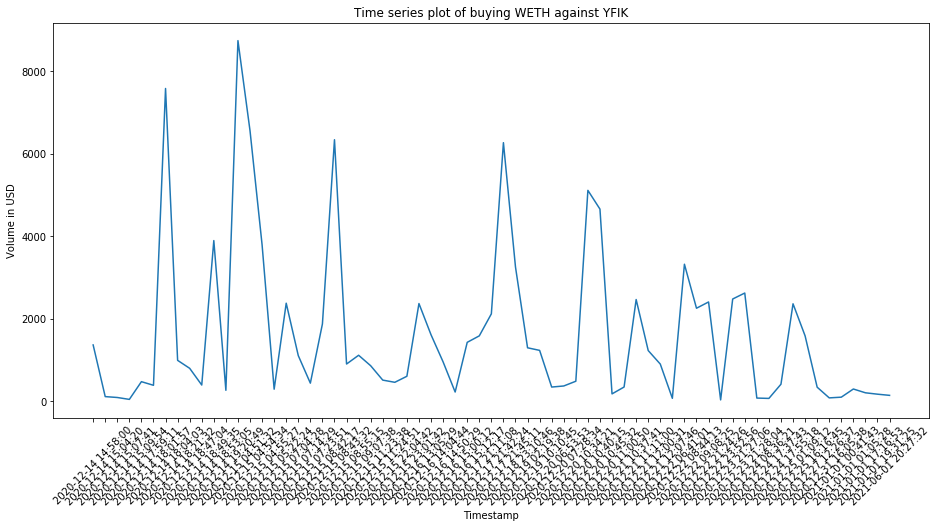

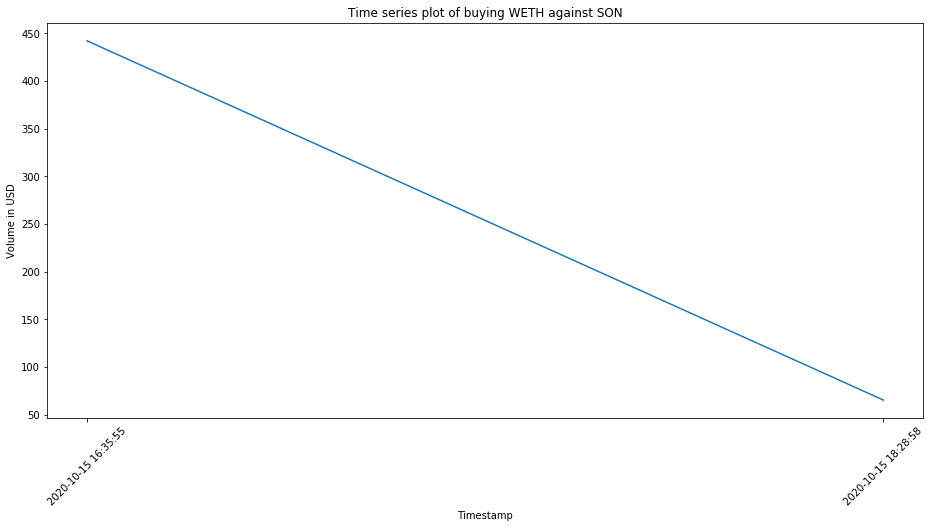

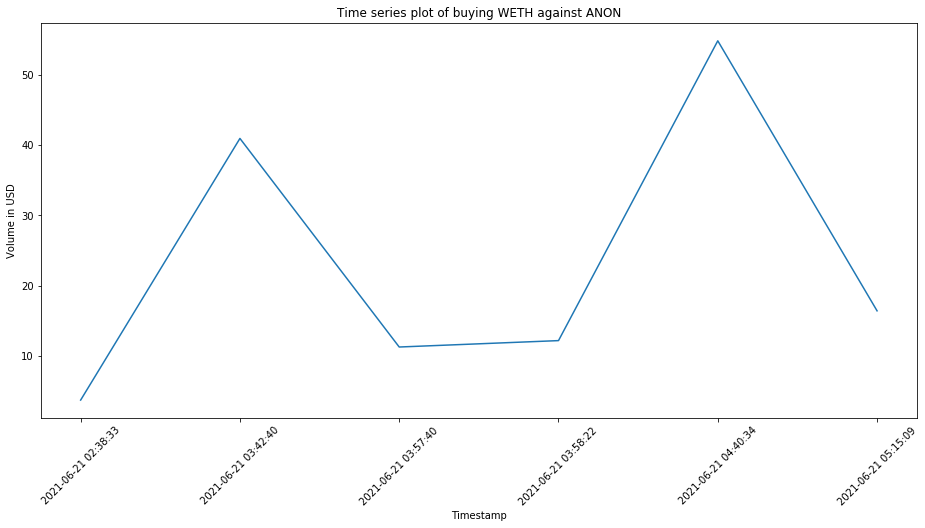

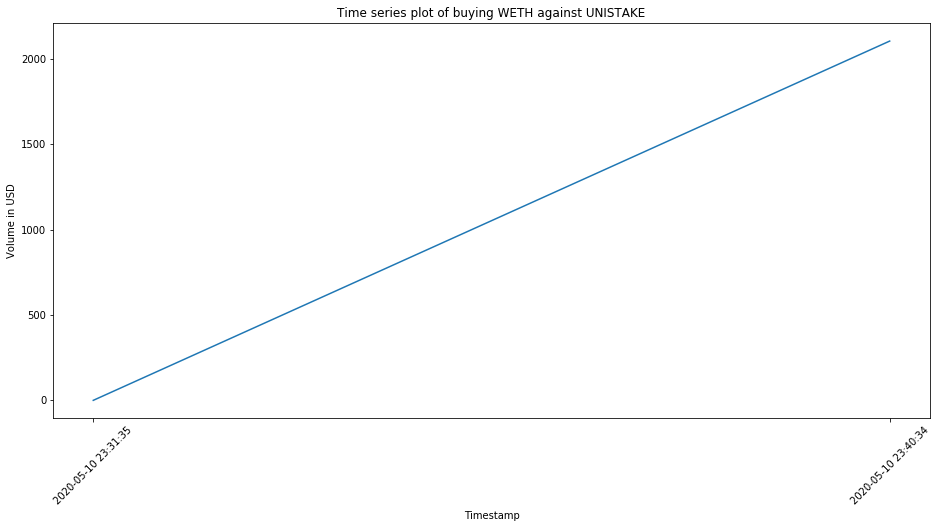

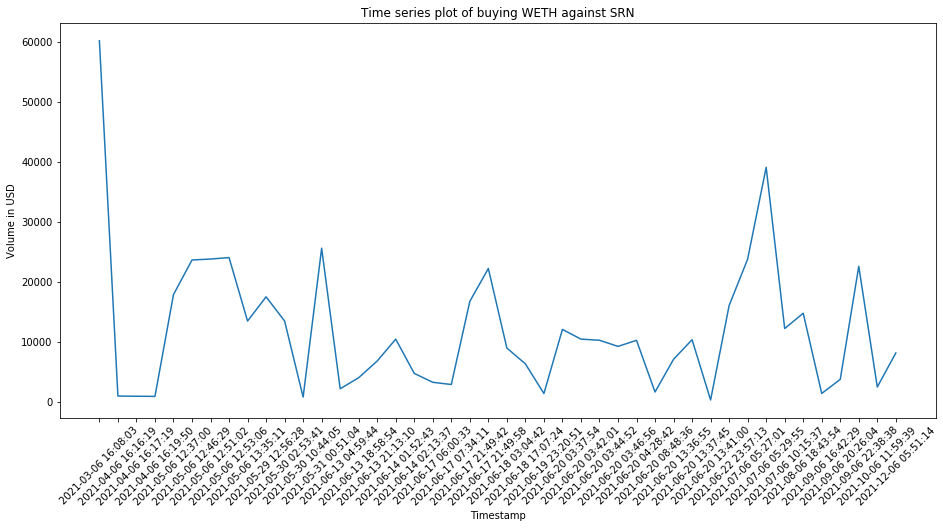

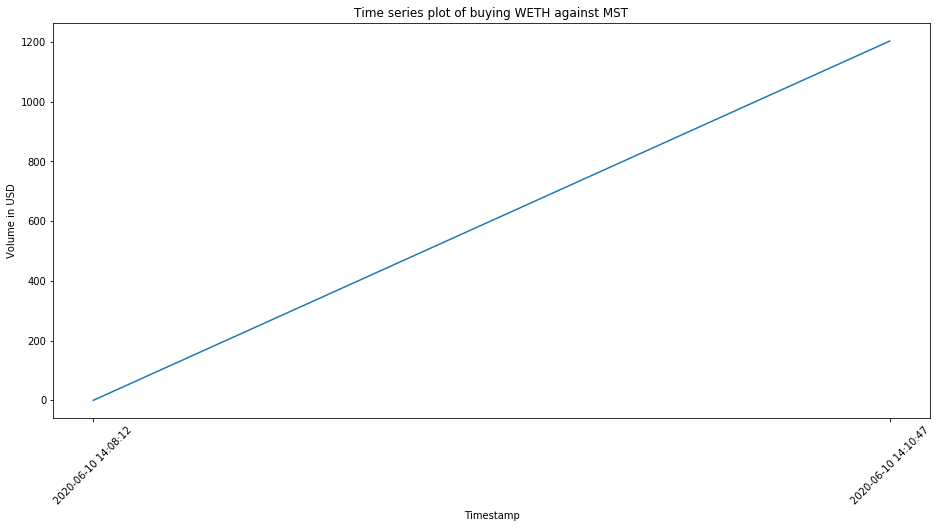

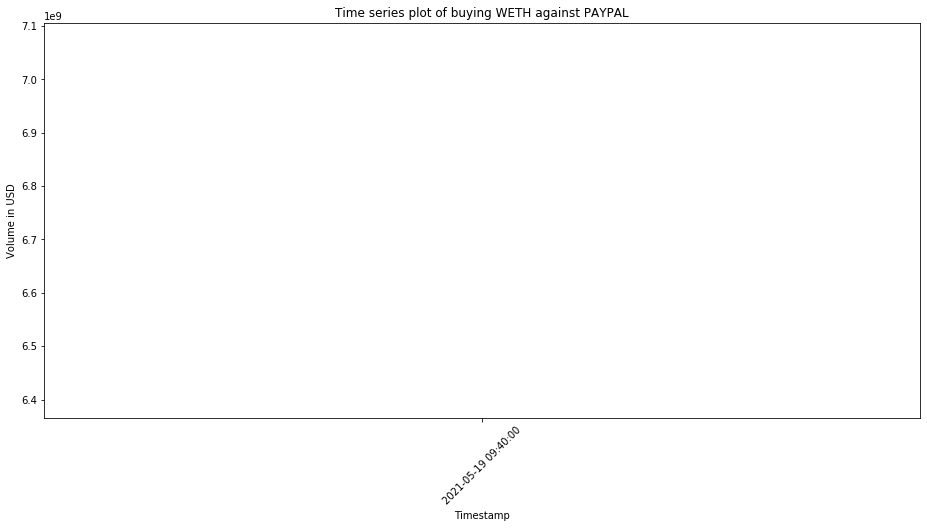

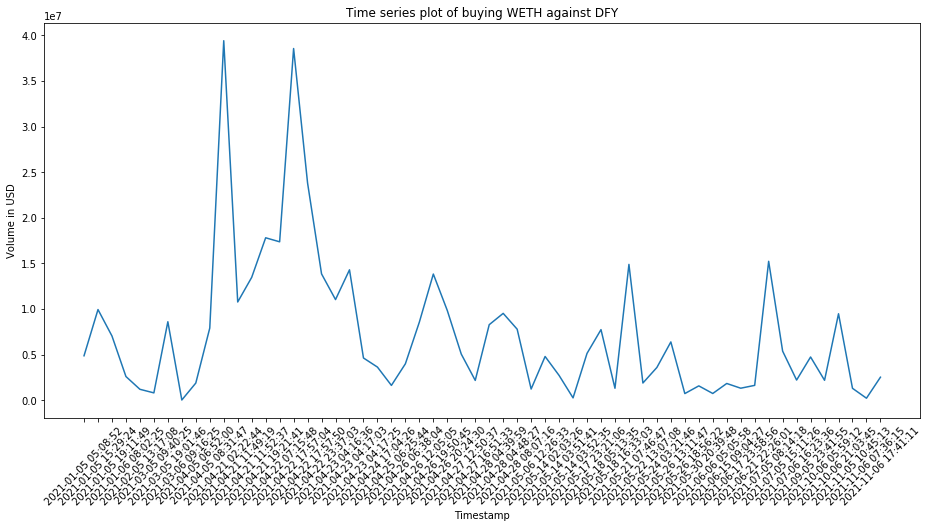

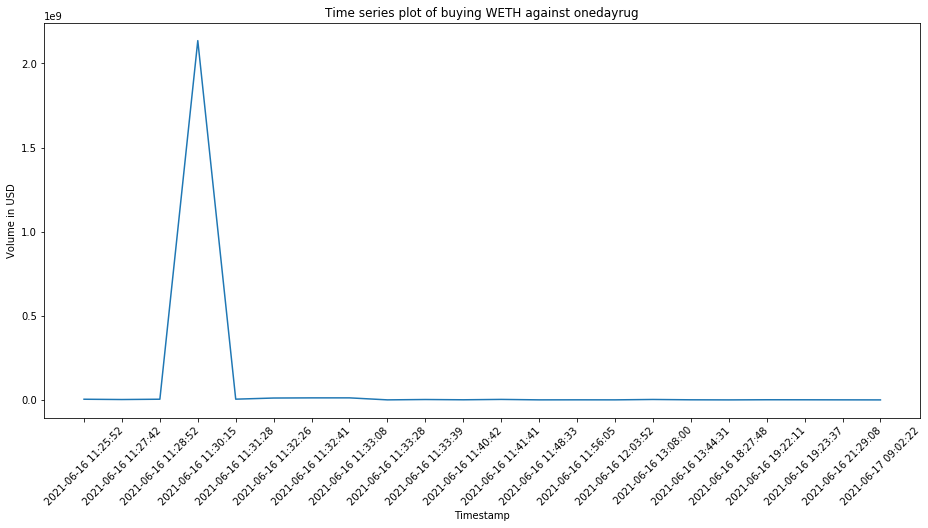

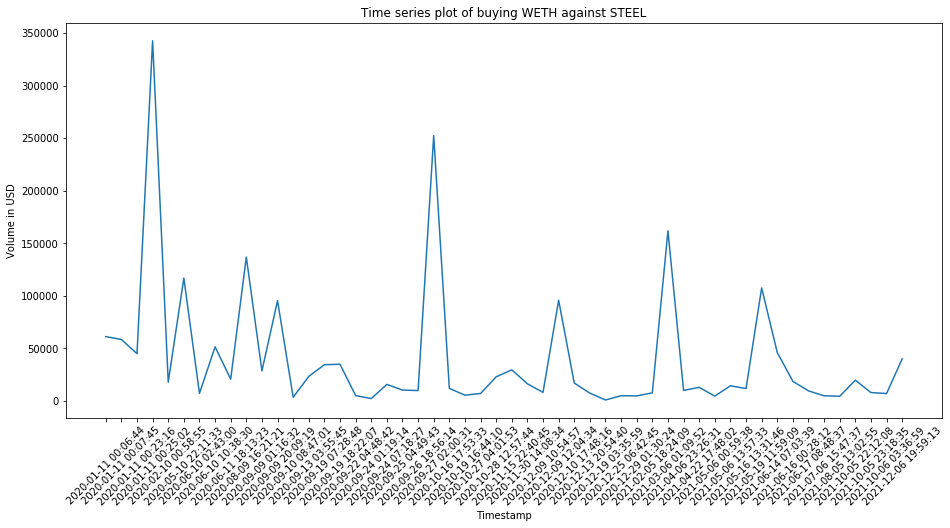

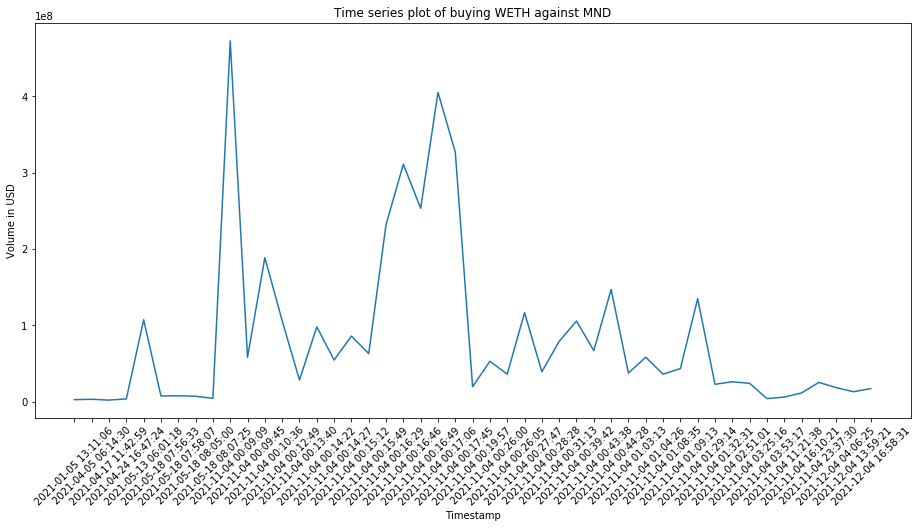

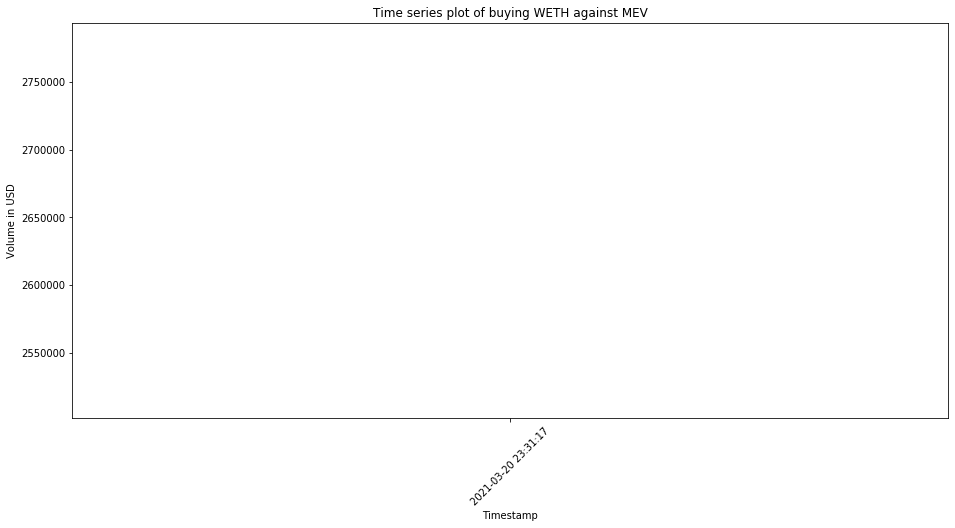

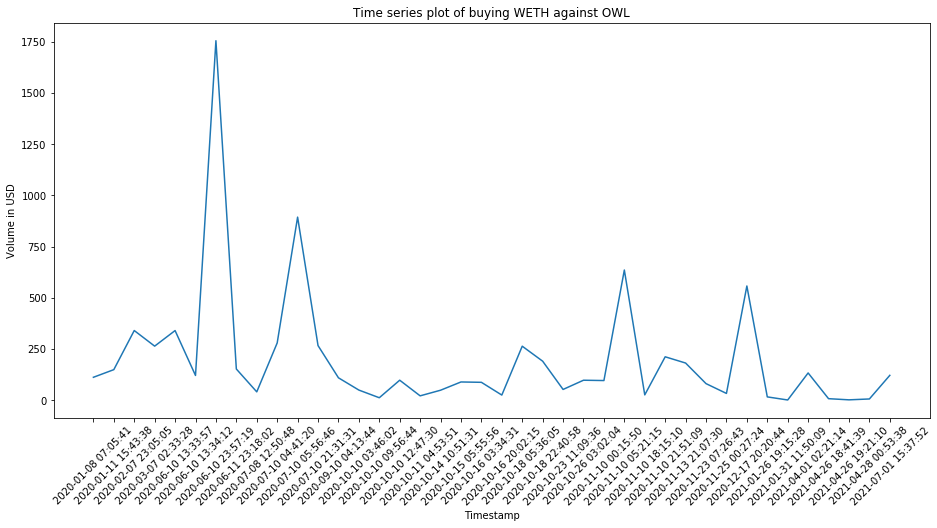

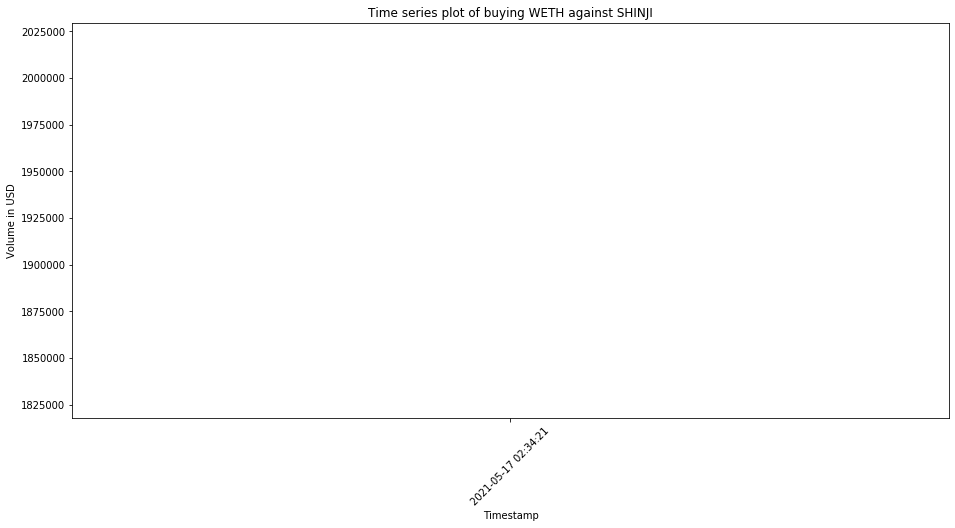

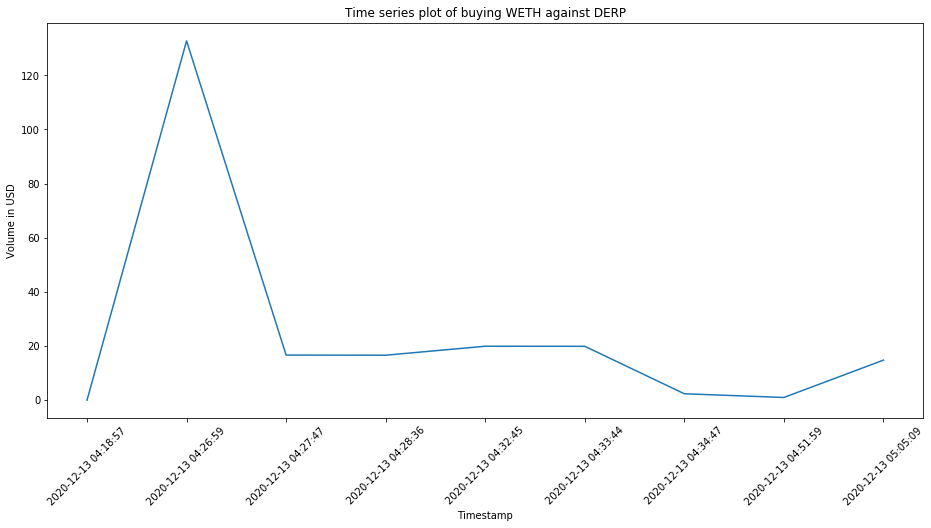

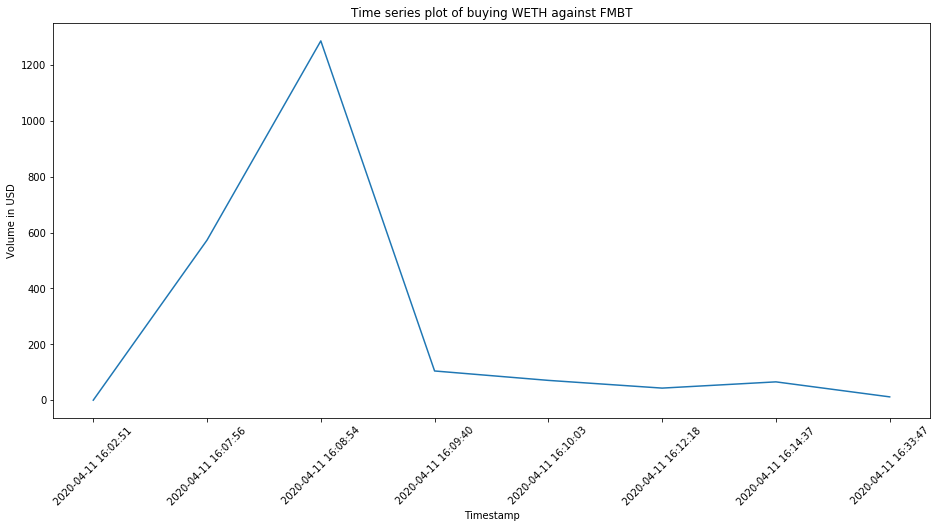

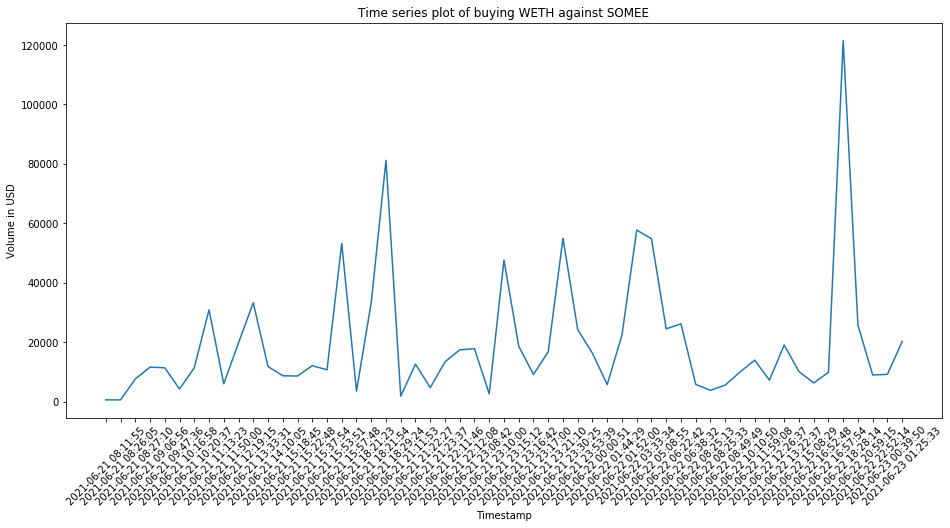

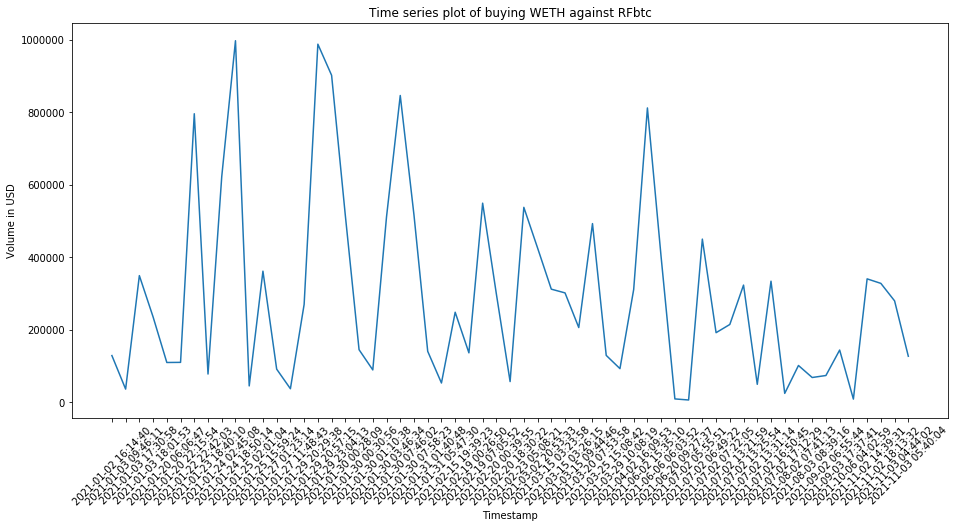

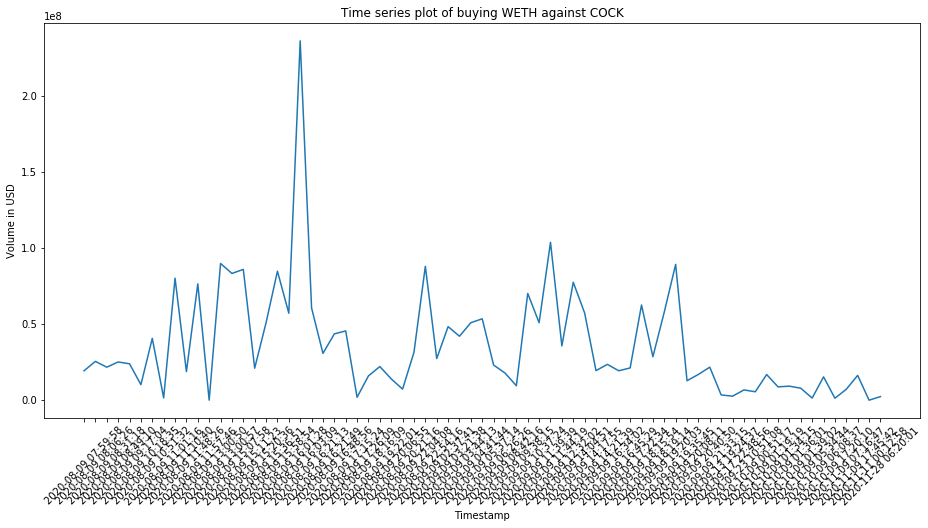

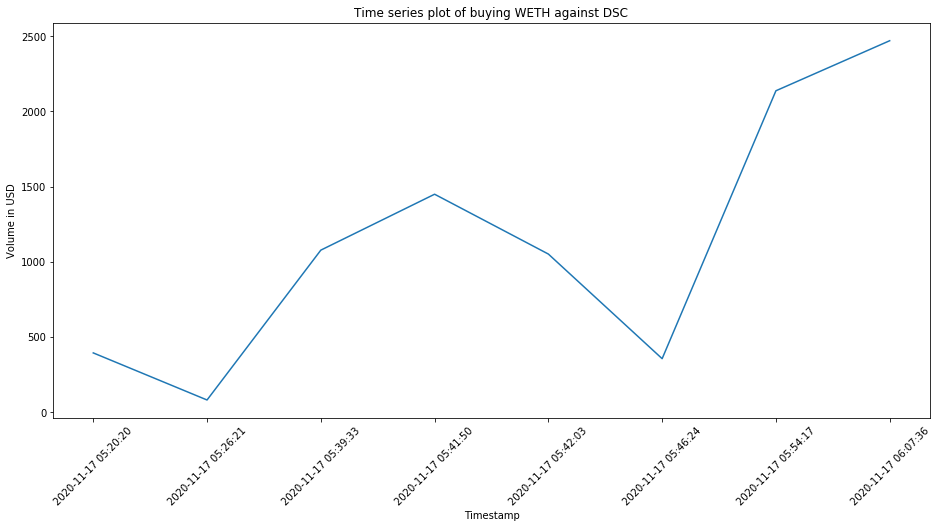

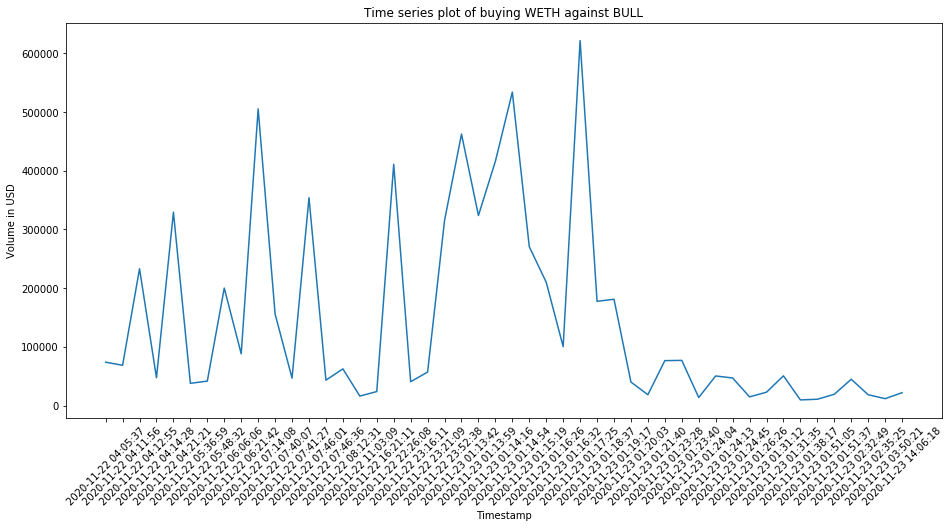

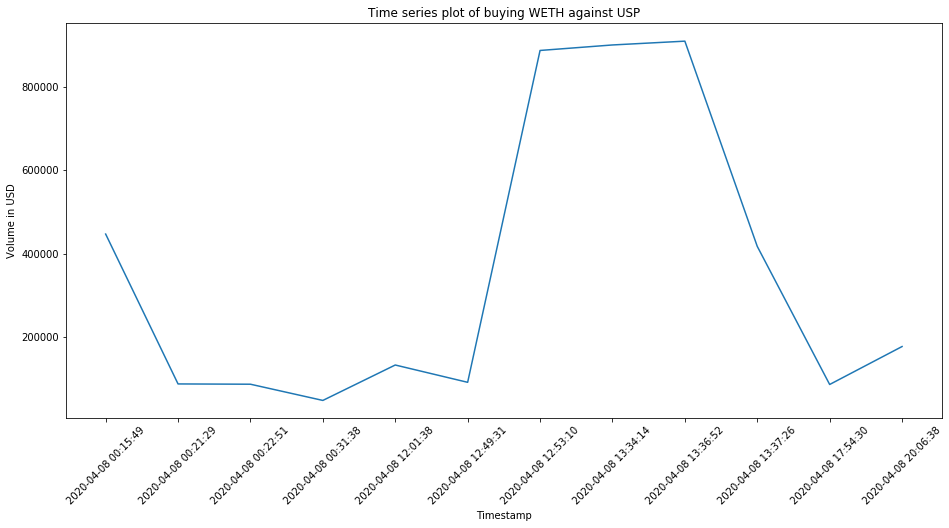

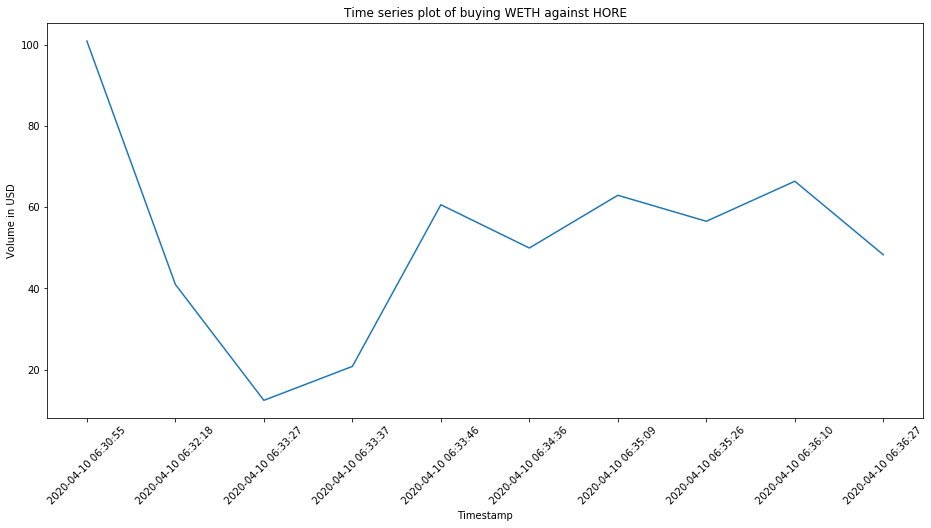

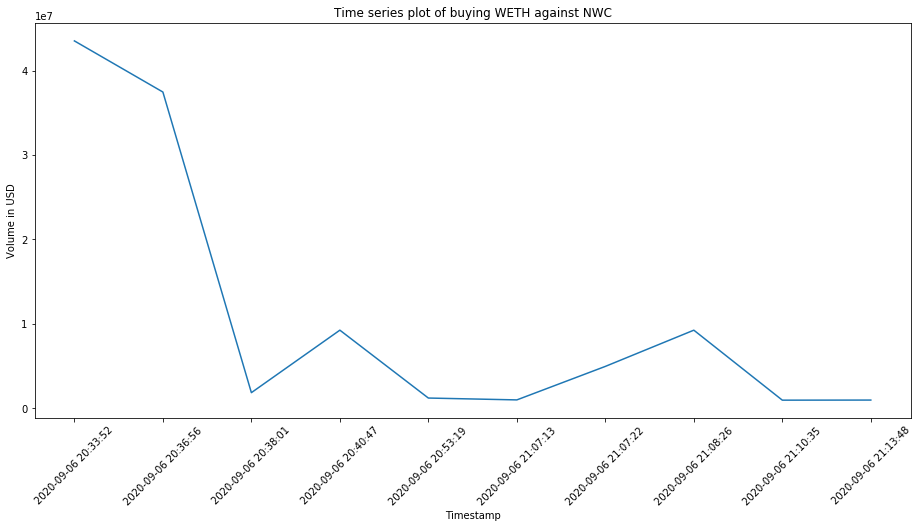

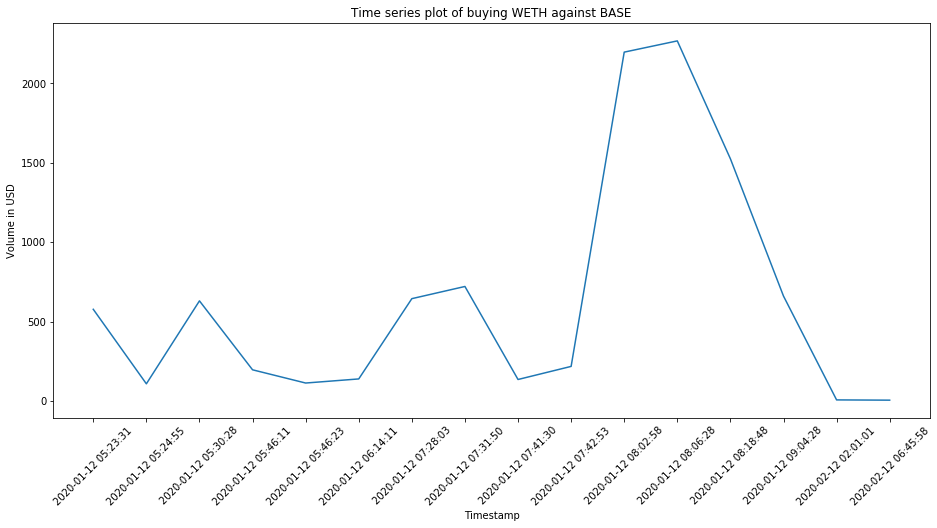

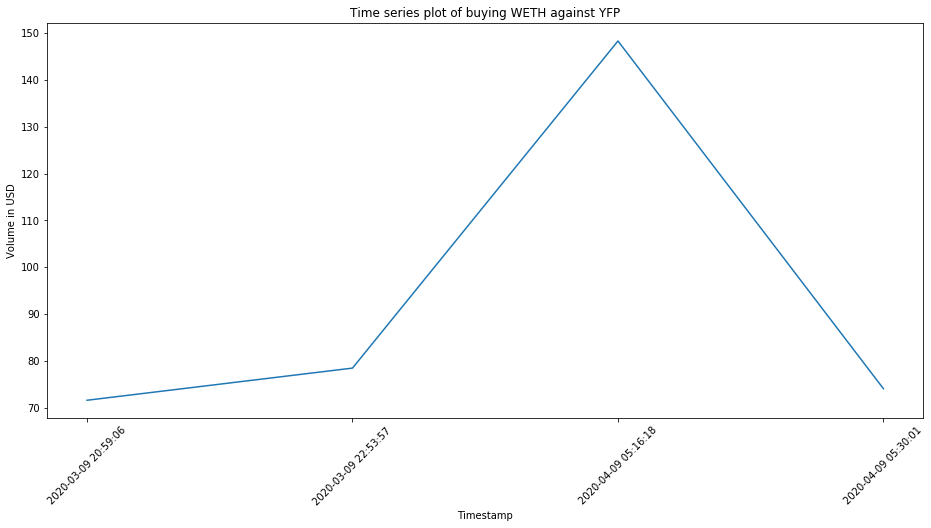

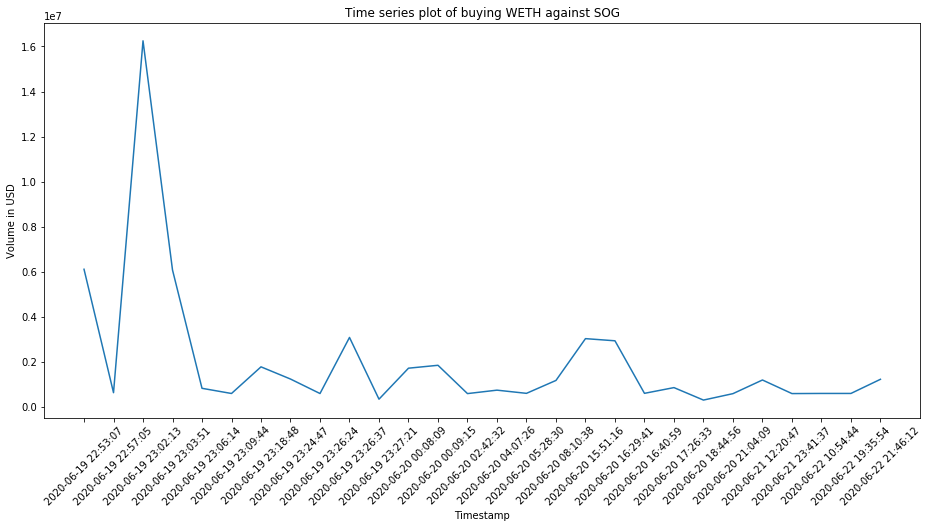

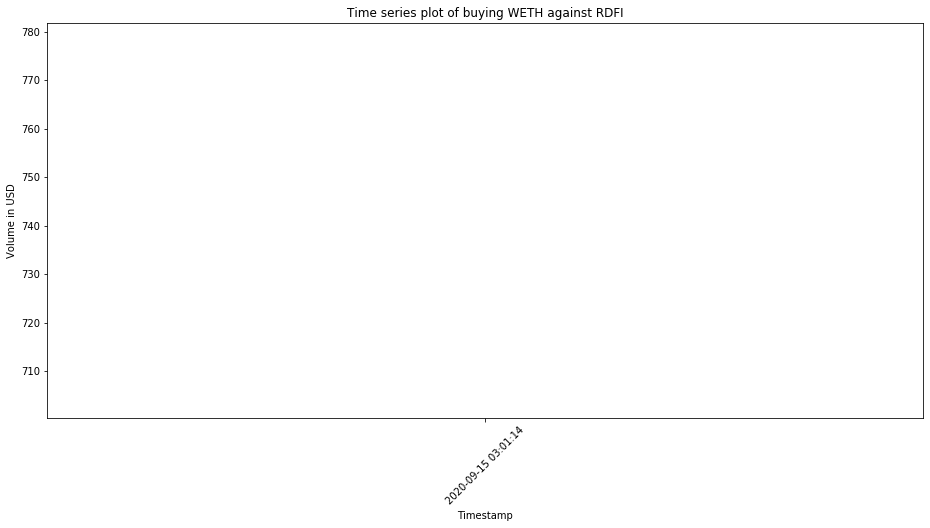

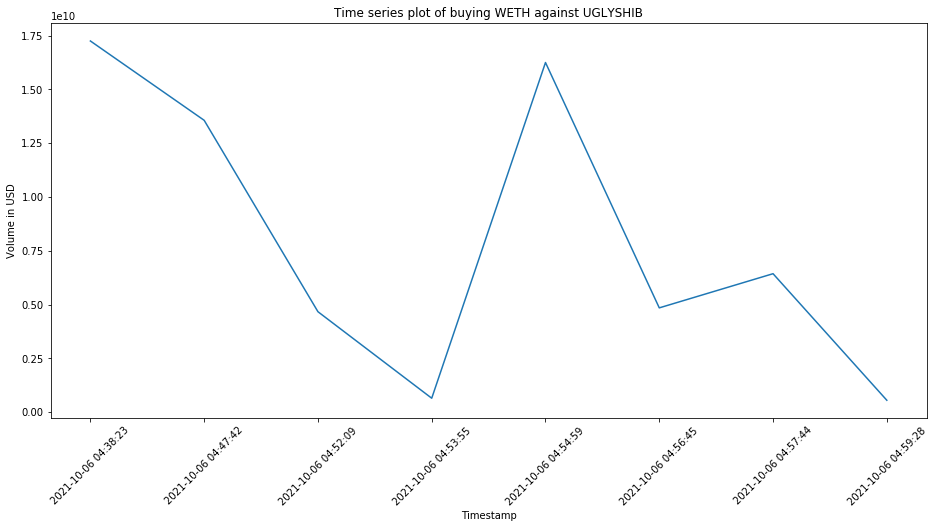

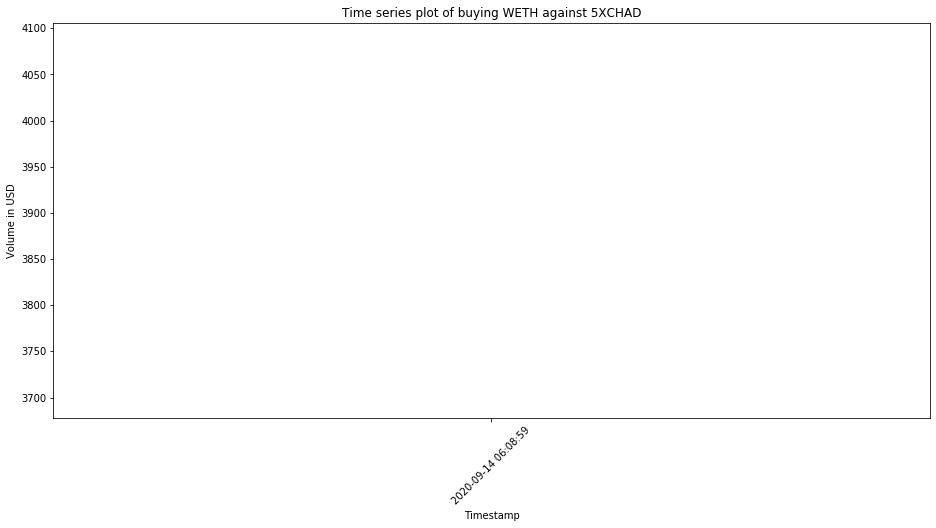

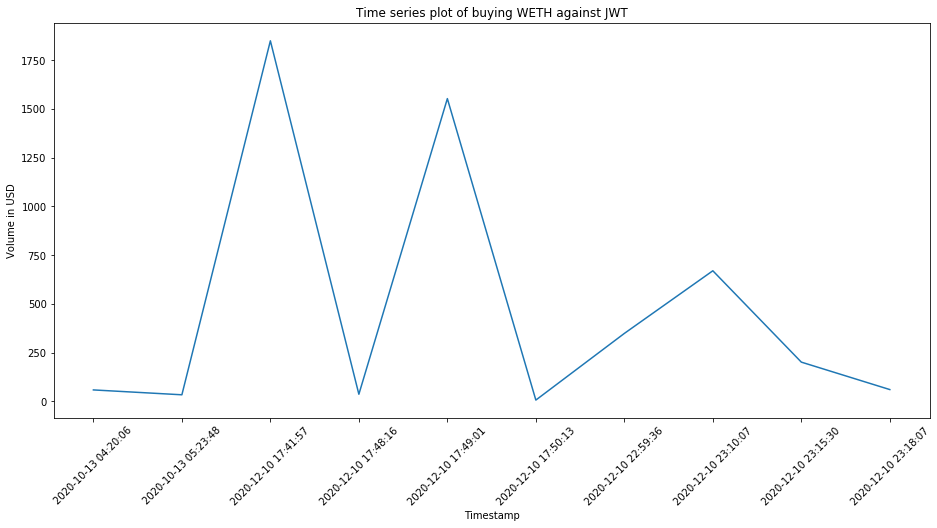

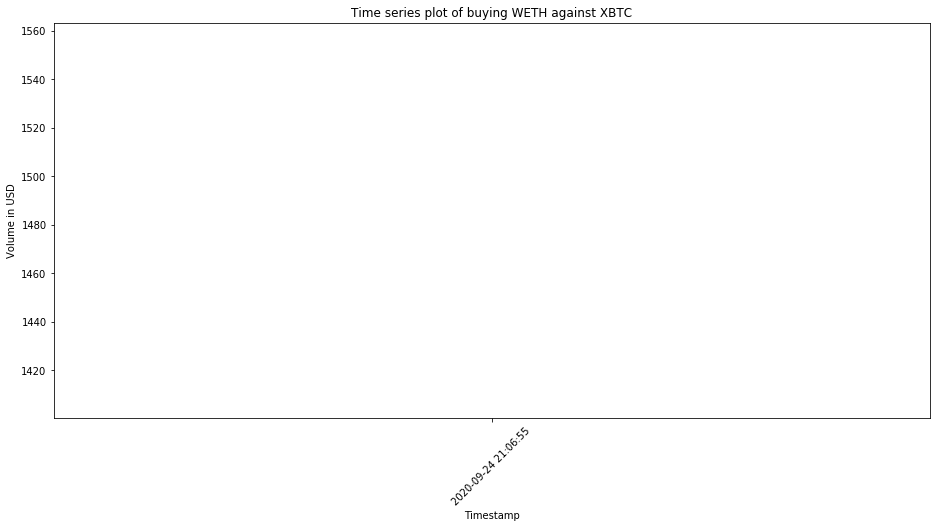

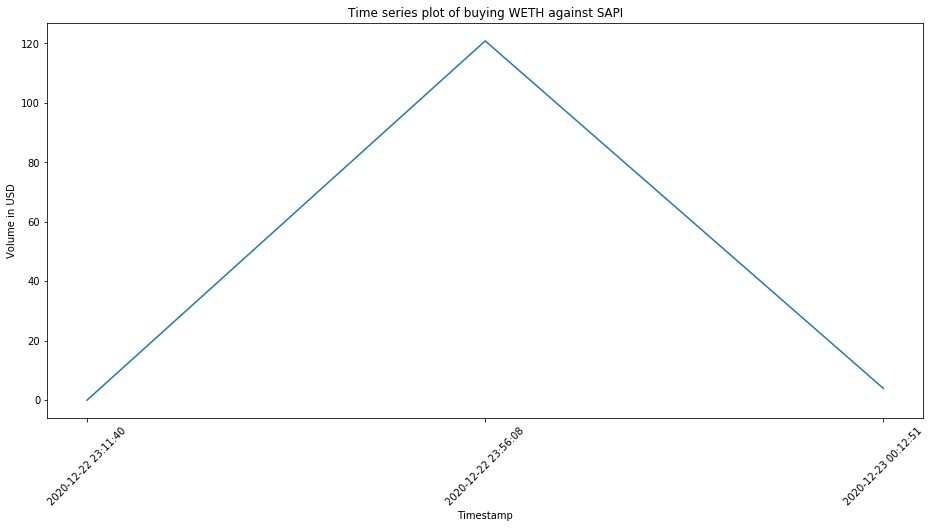

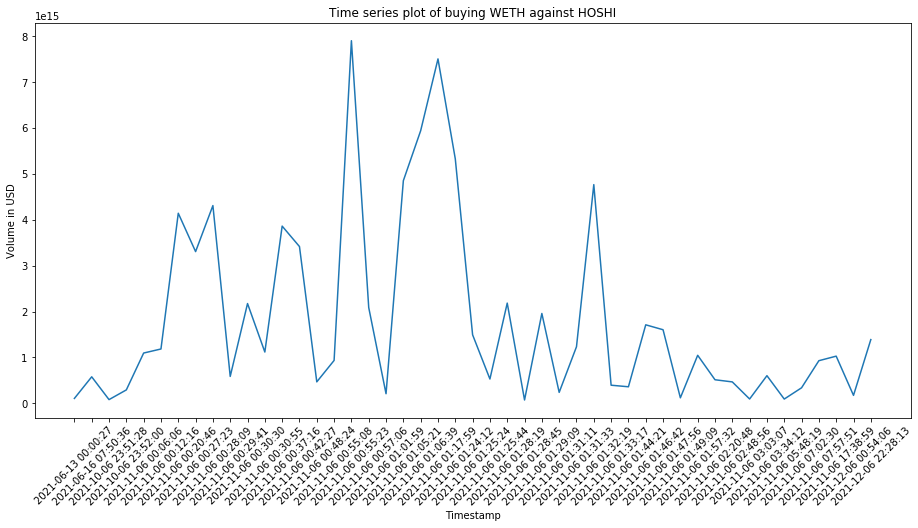

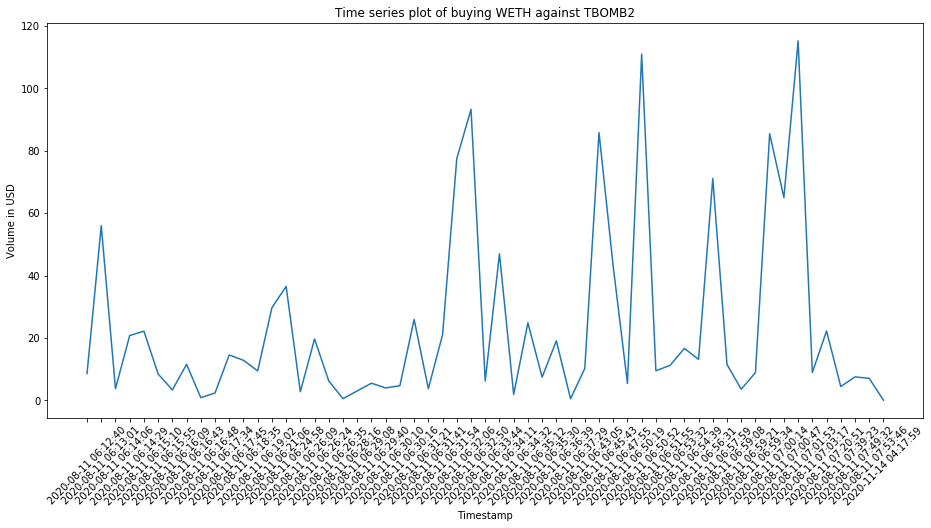

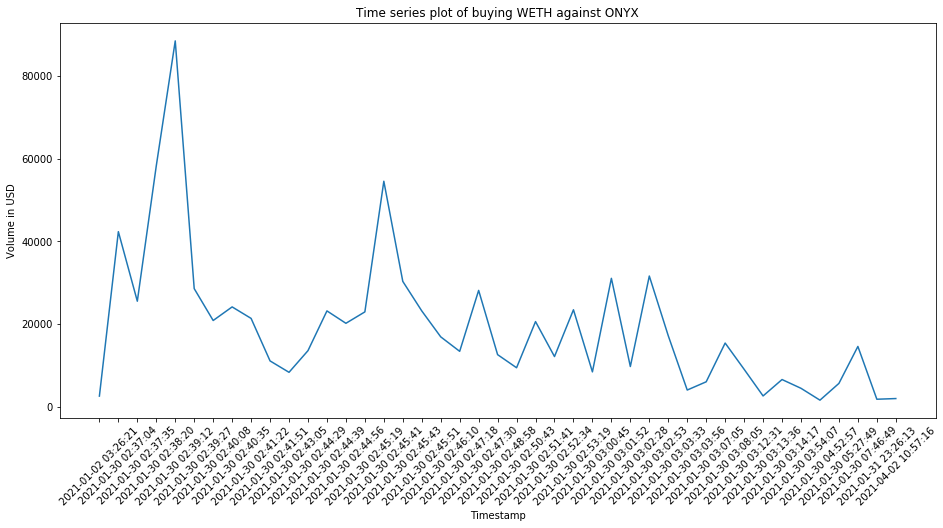

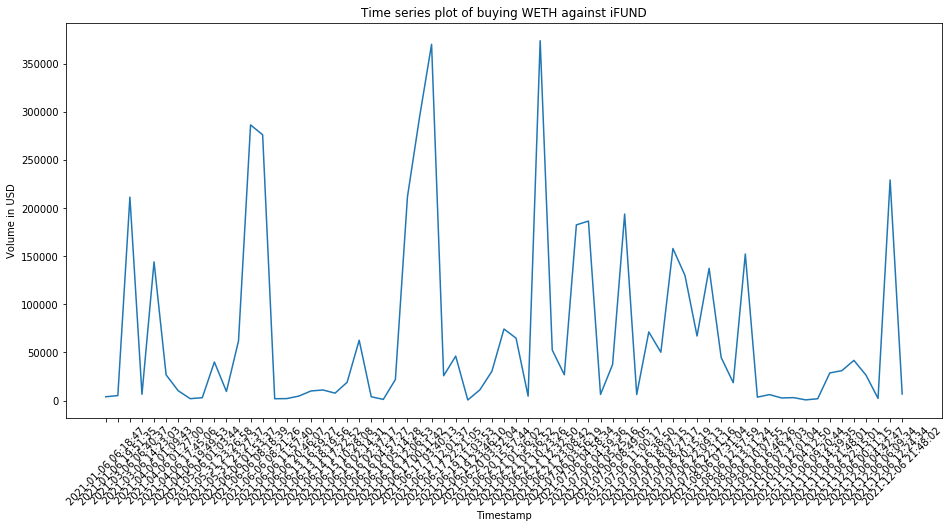

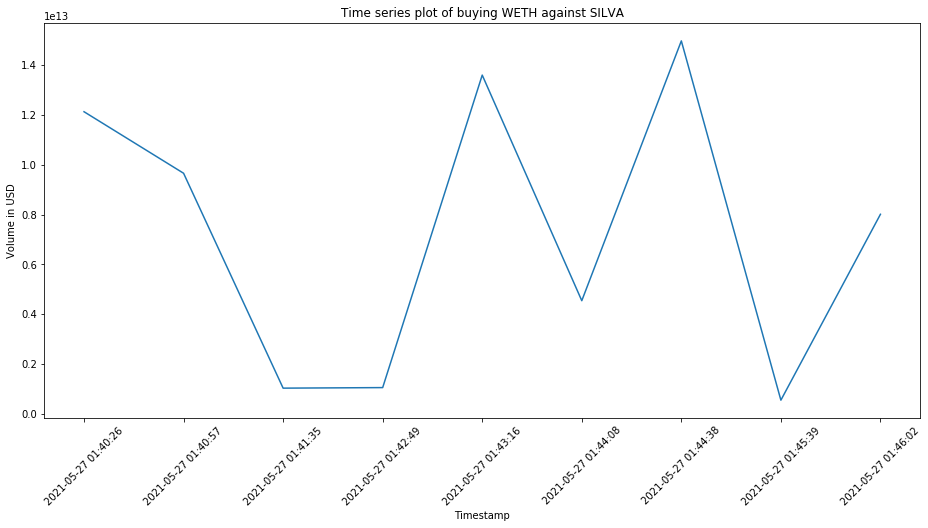

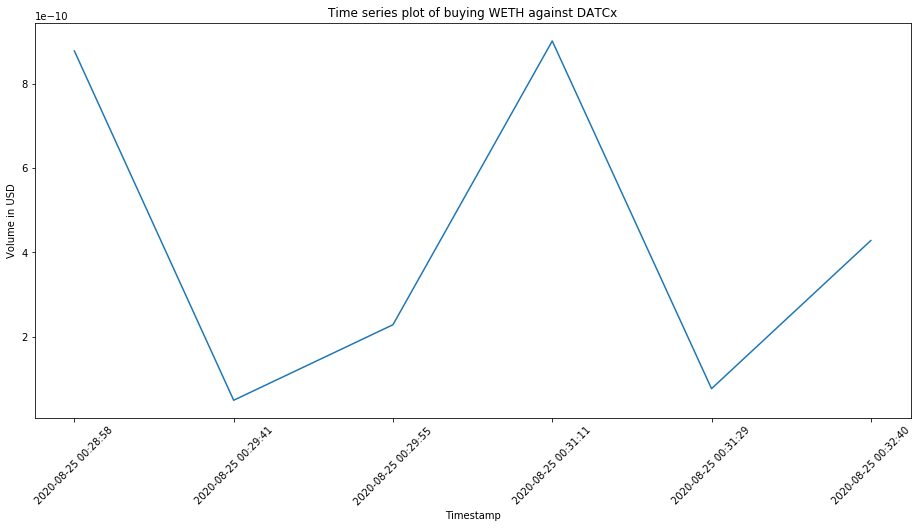

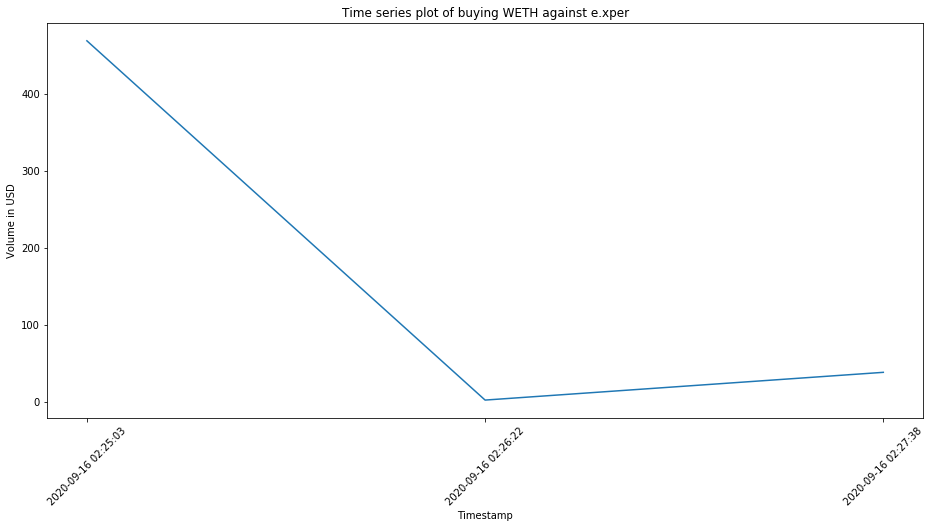

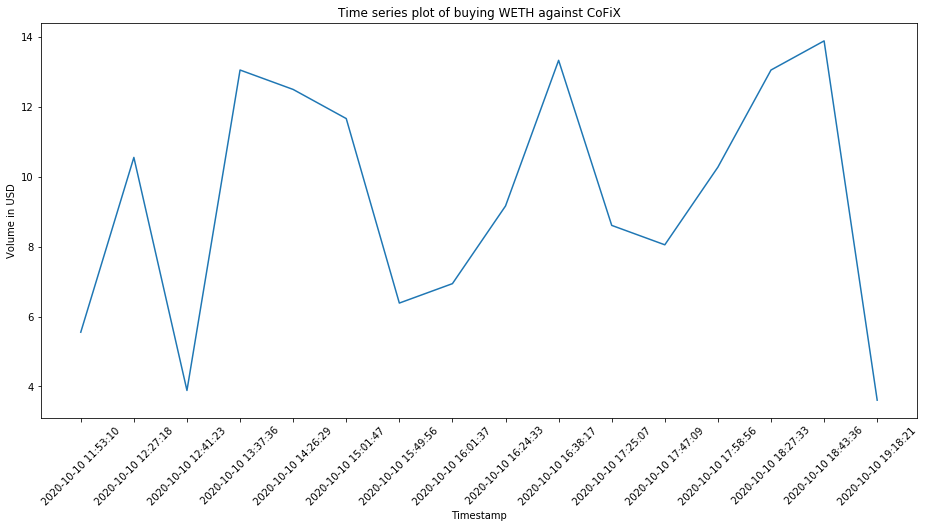

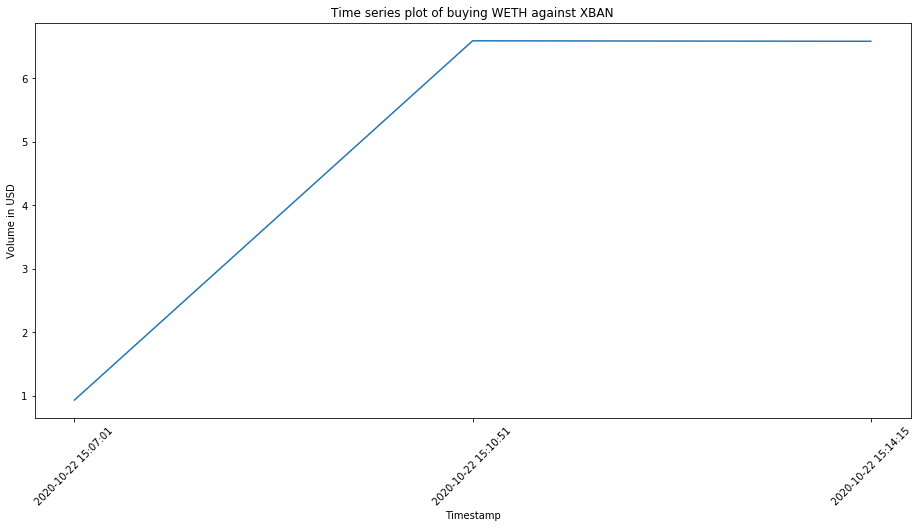

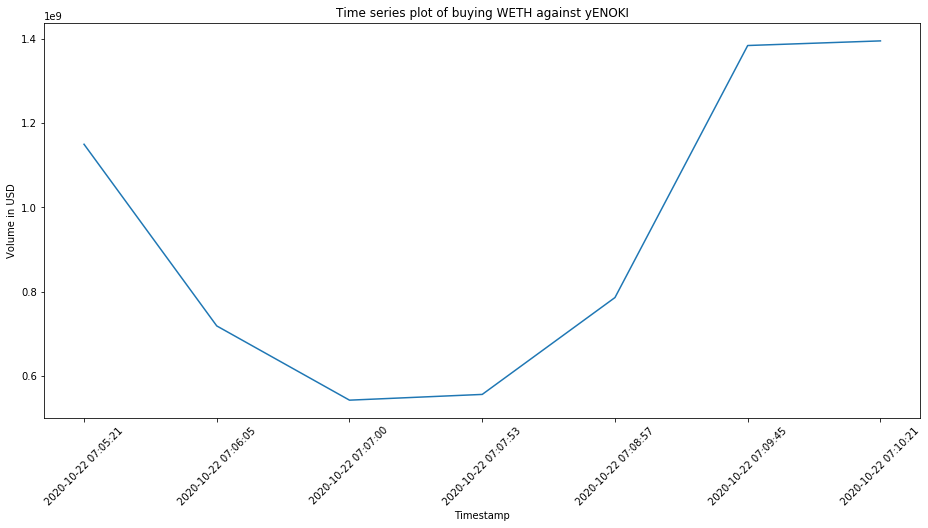

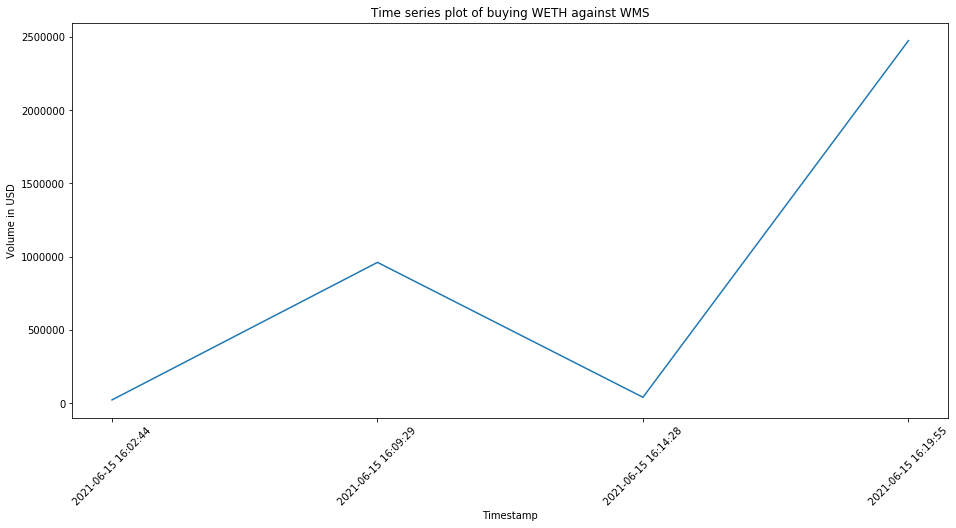

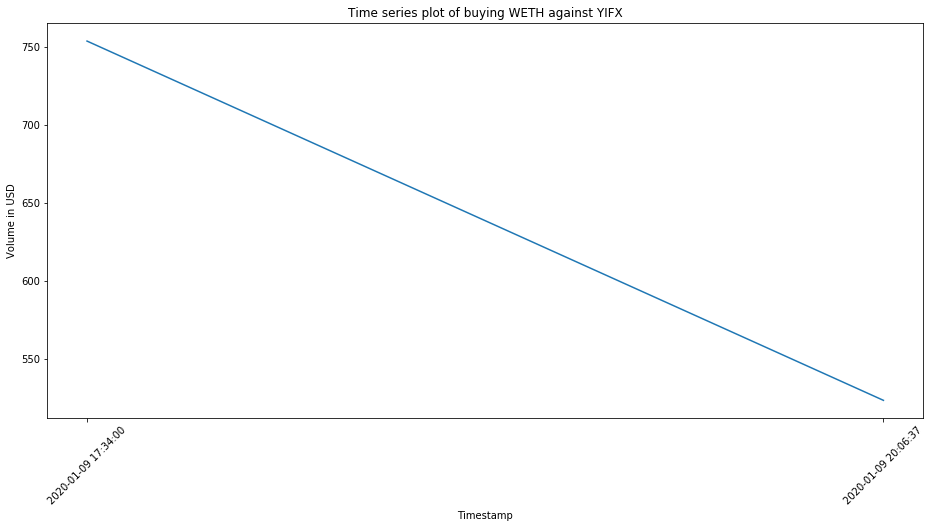

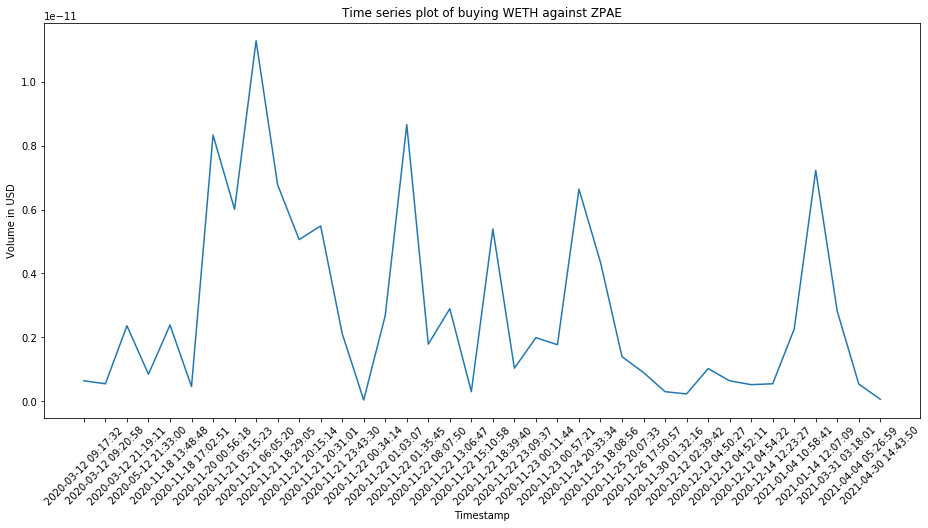

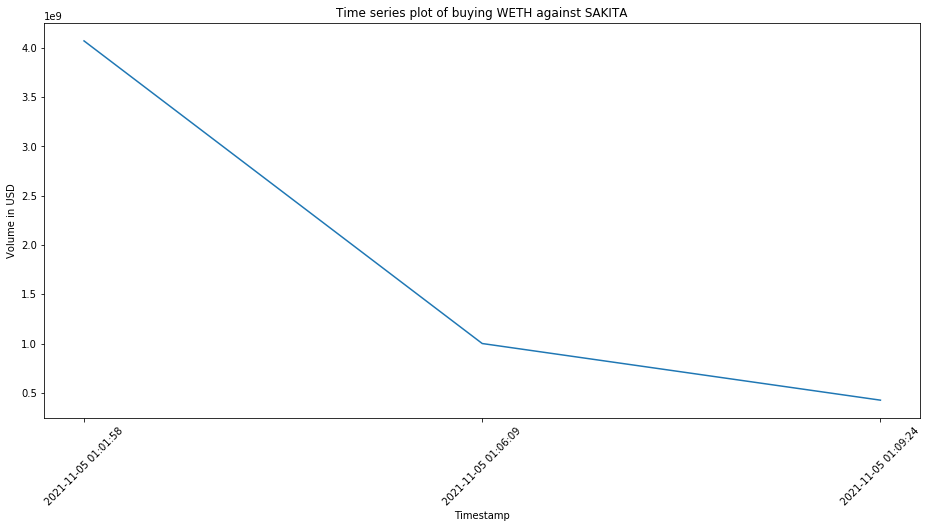

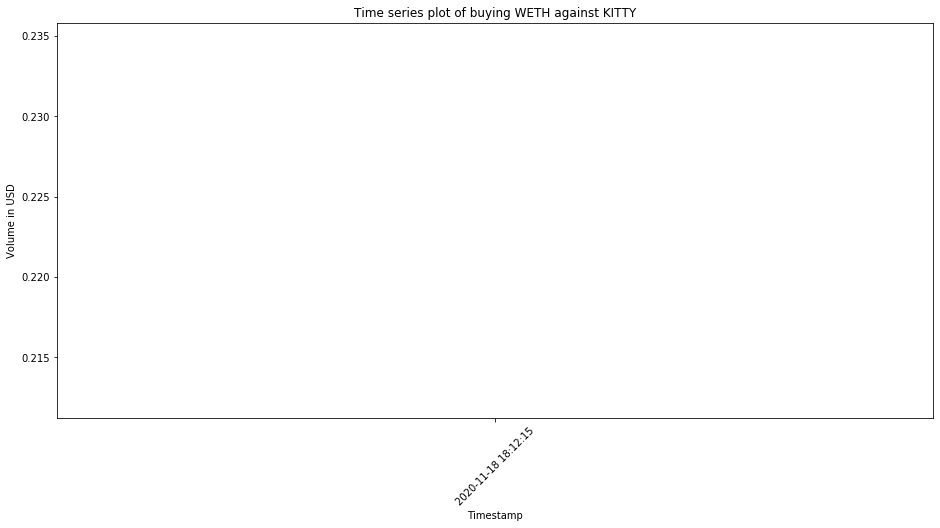

In [25]:
buyingtime_df = df[df['Side'] == 'Buy'].groupby(['Base_Currency', 'Quoted_Currency', 'Timestamp'])[['Volume in USD']].sum().reset_index()

for cur in list(set(buyingtime_df['Quoted_Currency'])) :
    temp_df = buyingtime_df[(buyingtime_df['Quoted_Currency'] == cur)]
    a4_dims = (15.7, 7.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.lineplot(x = "Timestamp", y = "Volume in USD", data = temp_df, ax=ax)
    plt.xticks(rotation=45)
    plt.title("Time series plot of buying WETH against " + cur)
    plt.show()